# Laboratory of Computational Physics mod.B

## Fifth assignment

### Group name: LoCPdown
### Components:
* Campesan Giulia (2027592)
* Faorlin Tommaso (2021857)
* Marcomini Alessandro (2024286)

The aim of this notebook is to implement some techniques concerning the Restricted Boltzmann Machines (RBM) in some corrupted data sequences. We will compare an econding of them via bit or spin levels.

In [1]:
#import packages
import numpy as np
import pandas as pd

from collections import OrderedDict

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

from IPython.display import Latex

In [2]:
#this cell contains some user defined function useful later on

def create_coord(np, x0):
    '''
    
    normalize in a box all the visible and hidden units
    
    '''
    x = [x0] * np
    y = list(range(np))
    for i in range(np):
        y[i] = y[i]/(np-1.) - 0.5 
        
    return (x,y)

def mycolor(val):
    '''
    
    define a custom color for lines and dots
    
    '''
    if val>0:
        return 'red'
    elif val<0:
        return 'blue'
    return 'black'

def plotgraph(M, epoch=0):
    '''
    
    plot the boltzmann layers and weights
    
    '''
    A = 2. / w.max()
    (x1, y1) = create_coord(L,0)
    (x2, y2) = create_coord(M,1)
    for i in range(L):
        for j in range(M):
            ex, ey, col = (x1[i], x2[j]), (y1[i], y2[j]), mycolor(w[i,j])
            plt.plot(ex, ey, col, zorder=1, lw=A*np.abs(w[i,j]))
    A = 300./(a.max()+b.max())
    for i in range(L):
        plt.scatter(x1[i], y1[i], s=A*np.abs(a[i]), zorder=2, c=mycolor(a[i]))
    plt.title(f'>0 red, <0 blue,epoch={epoch}')
    for j in range(M):
        plt.scatter(x2[j], y2[j], s=A*np.abs(b[j]), zorder=2, c=mycolor(b[j]))
    plt.title(f'>0 red, <0 blue,epoch={epoch}')
    plt.show()
    
def activate(v_in, wei, bias, DE, info=False):
    act = np.dot(v_in, wei) + bias
    prob = 1. / (1. + np.exp(-DE*act))
    n = len(act)
    v_out = np.full(n, vmin)
    v_out[np.random.random_sample(n) < prob] = 1
    if info:
        print('input=', v_in)
        print('act=', act)
        print('prob=', prob)
        print('out=', v_out)
        
    return(v_out)

def mountain_plot(betas, z):
    '''
    
    plots the moutain-shaped graph with the accuracy for a mesh of betas
    

    '''
    x, y = np.meshgrid(betas, betas)

    fig = plt.figure()
    ax = Axes3D(fig)

    #plot the surface.
    surf = ax.plot_surface(x,y, z, vmin=30.,vmax=90., cmap='gist_earth')

    #add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.set_xlabel('$\\beta$, positive phase')
    ax.set_ylabel('$\\beta$, negative phase')
    ax.set_zlabel('accuracy')
    ax.view_init(30,200)

    plt.show()
    
def mean_square_increment(dw):
    '''
    
    calculate the means squared increment given the weights
    
    '''
    total = 0
    for i in range(L):
        for j in range(M):
            total += dw[i,j]**2
    total /= L*M
    
    return total

def evaluate_beta(beta_p, beta_n, v0, v_uncurrupted, a, b, w):
    '''
    
    given the sequences before and after RBM, this function trains the RBM and
    compute the comparison with the uncurrupted data for different beta
    
    
    '''
    v2 = np.full((N, L), vmin)
    for n in range(N):
        h = activate(v0[n], w,b,GAP*beta_p)
        v2[n] = activate(h, w.T,a,GAP*beta_n)
    
    vdiff = np.sum(np.abs(v_uncurrupted-v2), axis=1)
    tot = np.sum(vdiff) / (1-np.min(v_uncurrupted))
    perc = np.unique(vdiff, return_counts=True)[1][0] / len(v_uncurrupted) * 100
    
    return tot, perc 


def training_RBM(M,w,a,b,info=True):
    
    
 
    
    #minibatches
    mini, m = 500, 0 
    #epochs
    nepoch = 50
    #l_rate
    l_rate = 1.
    #dw
    weights_spin = np.zeros(nepoch)

    for epoch in range(1, 1+nepoch):
        for n in range(N):
            if m==0:
                #initialize
                v_data, v_model = np.zeros(L), np.zeros(L) 
                h_data, h_model = np.zeros(M), np.zeros(M) 
                vh_data, vh_model = np.zeros((L,M)), np.zeros((L, M)) 

            #positive CD phase
            h = activate(v[n],w,b,GAP)
            #negative CD phase
            vf = activate(h, w.T,a,GAP)
            #positive CD nr 2
            hf = activate(vf,w,b, GAP)

            v_data += v[n]
            v_model += vf
            h_data += h
            h_model += hf
            vh_data += np.outer(v[n].T, h)
            vh_model += np.outer(vf.T, hf)

            m += 1
            if m==mini:
                C = l_rate / mini
                dw = C*(vh_data - vh_model)
                da = C*(v_data - v_model)
                db = C * (h_data - h_model)
                weights_spin[epoch-1] = mean_square_increment(dw)

                w += dw
                a += da
                b += db
                m = 0

        #randomize order
        np.random.shuffle(v)
        l_rate = l_rate / (0.05 * l_rate + 1)
        
        if info:
            if (epoch % 10 == 0):
                plotgraph(M,epoch)
                print(' l_rate=', l_rate)
    return w,a,b

## 1) Differences in $\beta$

We start by encoding the data in the 'spins' format, namely with +1 and -1 in the sequences. The aim of this first section is to see what happens if we change the temperature ($\beta$ parameter in the sigmoid function) in our RBM model.

In [46]:
#we load the sequences generated with the file coded at lesson

#corruption probability
q = 0.1

fname='DATA/dataRBM_q'+str(q)+'.csv'
v = np.loadtxt(fname, delimiter=',', dtype=int)
N=len(v)
L=len(v[0])

for n in range(10):
    print(v[n])
    
#here we select the encoding
SPINS = True

if SPINS:
    vmin = -1
    GAP = 2
    v =  2*v -1
else:
    vmin = 0
    GAP = 1
    
#store initial values before shuffling
v0 = np.copy(v)

[0 1 0 0 1 0 1 1]
[1 1 0 1 1 0 0 1]
[0 1 1 1 0 0 1 1]
[0 0 1 1 1 1 0 0]
[0 0 1 1 0 0 1 0]
[1 1 0 0 1 0 0 0]
[0 1 1 0 1 1 0 0]
[1 1 0 0 0 0 1 1]
[1 0 0 1 1 1 0 1]
[1 0 0 0 0 0 1 0]


In [47]:
M=3
sigma = np.sqrt(4. / float(N+M))

w = sigma * (2*np.random.rand(L, M) - 1) #from -sigma to sigma 
a = sigma * (2*np.random.rand(L) - 1)
b = np.zeros(M)

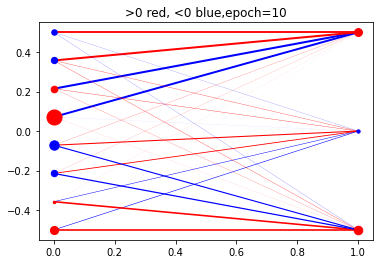

 l_rate= 0.6666666666666663


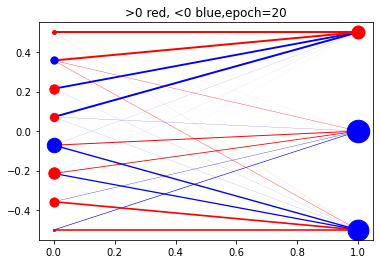

 l_rate= 0.5


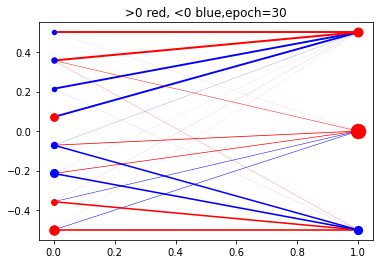

 l_rate= 0.4000000000000001


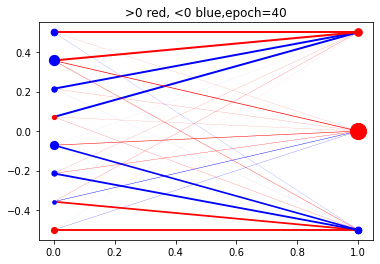

 l_rate= 0.3333333333333335


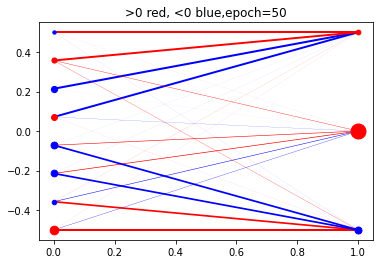

 l_rate= 0.28571428571428586


In [48]:
#minibatches
mini, m = 500, 0 
#epochs
nepoch = 50
#l_rate
l_rate = 1.
#dw
weights_spin = np.zeros(nepoch)

for epoch in range(1, 1+nepoch):
    for n in range(N):
        if m==0:
            #initialize
            v_data, v_model = np.zeros(L), np.zeros(L) 
            h_data, h_model = np.zeros(M), np.zeros(M) 
            vh_data, vh_model = np.zeros((L,M)), np.zeros((L, M)) 

        #positive CD phase
        h = activate(v[n],w,b,GAP)
        #negative CD phase
        vf = activate(h, w.T,a,GAP)
        #positive CD nr 2
        hf = activate(vf,w,b, GAP)

        v_data += v[n]
        v_model += vf
        h_data += h
        h_model += hf
        vh_data += np.outer(v[n].T, h)
        vh_model += np.outer(vf.T, hf)

        m += 1
        if m==mini:
            C = l_rate / mini
            dw = C*(vh_data - vh_model)
            da = C*(v_data - v_model)
            db = C * (h_data - h_model)
            weights_spin[epoch-1] = mean_square_increment(dw)
            w += dw
            a += da
            b += db
            m = 0
            
    #randomize order
    np.random.shuffle(v)
    l_rate = l_rate / (0.05 * l_rate + 1)
    if (epoch % 10 == 0):
        plotgraph(M,epoch)
        print(' l_rate=', l_rate)

## 2) corrupted/non-corrupted comparison

In [49]:
#number of different betas and linspace
n_betas = 11
betas = np.linspace(0.5, 5.5, n_betas)

#probability (null) of corruption for perfectly-generated data
q1 = 0
fname='DATA/dataRBM_q'+str(q1)+'.csv'
v_uncurrupted = np.loadtxt(fname, delimiter=',', dtype=int)

if SPINS:
    vmin = -1
    GAP = 2
    v_uncurrupted =  2*v_uncurrupted -1
else:
    vmin = 0
    GAP = 1

tots, percs = np.zeros((n_betas, n_betas)), np.zeros((n_betas, n_betas))

for i in range(n_betas):
    for j in range(n_betas):
        tot, perc = evaluate_beta(betas[j], betas[i], v0, v_uncurrupted, a, b, w)
        tots[i,j] = tot
        percs[i, j] = perc 

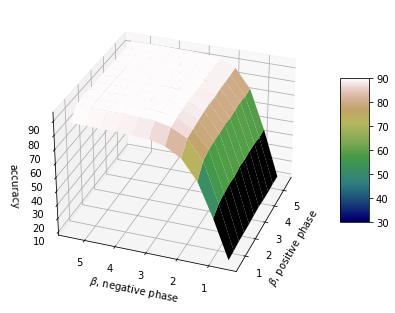

In [50]:
mountain_plot(betas, percs)

In [51]:
#accuracy of the dataset after denoising
acc_at_denois = np.max(percs)

#accuracy of the dataset before denoising
vdiff = np.sum(np.abs(v_uncurrupted-v0), axis=1)
tot = np.sum(vdiff) / (1-np.min(v_uncurrupted))
acc_bf_denois = np.unique(vdiff, return_counts=True)[1][0] / len(v_uncurrupted) * 100

In order to understand whether the correction is working, we compare the accuracy, intended as the percentage of strings identical to the correspoonding one in the uncorrupted dataframe, before and after the denoising.

Before the denoising, the accuracy is equal to 43.2$\%\sim0.9^8\times 100\sim43\%$, that is the theoretical probability to obtain two equal strings if the bit-flip probability is 0.9.

After the training we reach an accuracy of about 94%, almost the double of the one before denoising.
We can then conlcude that the correction has been working succesfully.


## 3a) Introducing a fifth state

We now see what happens if we add a fifth state of the kind '**11111111**'.

In [9]:
q = 0.1

fname='DATA/dataRBM_q'+str(q)+'_seq4.csv'
v = np.loadtxt(fname, delimiter=',', dtype=int)
N=len(v)
L=len(v[0])
print(f'each of N={N}data samples has L={L} digits')

for n in range(10):
    print(v[n])

SPINS = True
if SPINS:
    vmin = -1
    GAP = 2
    v =  2*v -1
else:
    vmin = 0
    GAP = 1
    
#store initial values before shuffling
v0 = np.copy(v)

each of N=10000data samples has L=8 digits
[1 1 1 1 1 1 1 0]
[1 1 1 0 1 0 0 1]
[0 0 1 1 1 0 0 1]
[1 0 1 1 1 1 0 0]
[1 0 1 1 1 1 1 1]
[1 1 0 0 1 0 1 1]
[1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1]
[0 0 1 1 1 0 0 0]
[1 1 0 0 1 1 0 0]


In [10]:
#we construct here our RBM initializing randomly the weights

#number of hidden units
M = 4

sigma = np.sqrt(4. / float(N+M))

w = sigma * (2*np.random.rand(L, M) - 1) #from -sigma to sigma 
a = sigma * (2*np.random.rand(L) - 1)
b = np.zeros(M)

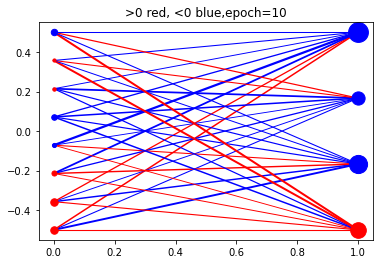

 l_rate= 0.6666666666666663


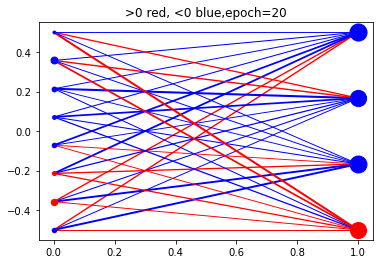

 l_rate= 0.5


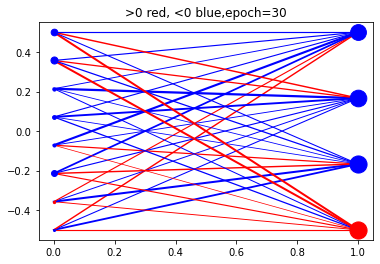

 l_rate= 0.4000000000000001


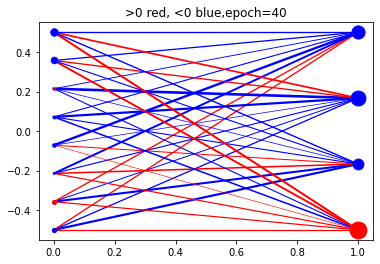

 l_rate= 0.3333333333333335


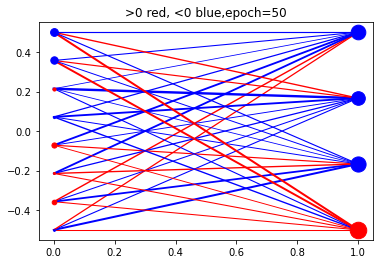

 l_rate= 0.28571428571428586


In [11]:
w,a,b= training_RBM(M,w,a,b)

In [12]:
#probability (null) of corruption for perfectly-generated data
q1 = 0

n_betas = 5
betas = np.linspace(0.5, 5.5, n_betas)

fname='DATA/dataRBM_q'+str(q1)+'_seq4.csv'
v_uncurrupted = np.loadtxt(fname, delimiter=',', dtype=int)

if SPINS:
    vmin = -1
    GAP = 2
    v_uncurrupted =  2*v_uncurrupted -1
else:
    vmin = 0
    GAP = 1

tots, percs = np.zeros((n_betas, n_betas)), np.zeros((n_betas, n_betas))

for i in range(n_betas):
    for j in range(n_betas):
        tot, perc = evaluate_beta(betas[j], betas[i], v0, v_uncurrupted, a, b, w)
        tots[i,j] = tot
        percs[i, j] = perc 

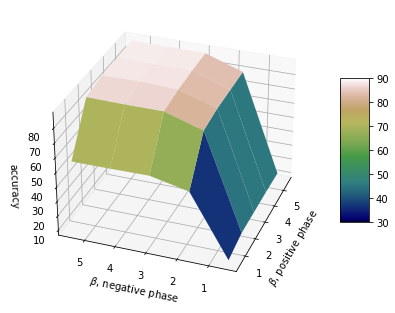

In [13]:
mountain_plot(betas, percs)

In [14]:
#accuracy of the dataset after denoising
acc_at_denois = np.max(percs)

#accuracy of the dataset before denoising
vdiff = np.sum(np.abs(v_uncurrupted-v0), axis=1)
tot = np.sum(vdiff) / (1-np.min(v_uncurrupted))
acc_bf_denois = np.unique(vdiff, return_counts=True)[1][0] / len(v_uncurrupted) * 100

print(acc_at_denois, acc_bf_denois)

88.8 43.01


Cambiamo solo un beta fissato ad un certo valore della montagna e poi cambiamo sia M che l'altro beta in una meshgrid.

## 3b) Introducing a sixth state

We now see what happens if we add a sixth state of the kind '**10101000**'.

In [15]:
q = 0.1

fname='DATA/dataRBM_q'+str(q)+'_seq45.csv'
v = np.loadtxt(fname, delimiter=',', dtype=int)
N=len(v)
L=len(v[0])
print(f'each of N={N}data samples has L={L} digits')

for n in range(10):
    print(v[n])

SPINS = True
if SPINS:
    vmin = -1
    GAP = 2
    v =  2*v -1
else:
    vmin = 0
    GAP = 1
    
#store initial values before shuffling
v0 = np.copy(v)

each of N=10000data samples has L=8 digits
[1 1 1 1 1 1 1 0]
[1 1 1 0 1 0 0 1]
[1 0 1 0 1 0 0 1]
[0 1 1 0 0 1 1 1]
[1 0 1 1 0 0 1 1]
[1 1 1 1 1 1 1 1]
[0 0 1 1 0 0 1 1]
[0 0 1 1 1 1 0 0]
[1 0 1 1 1 1 0 0]
[1 0 0 1 0 0 1 1]


In [16]:
#we construct here our RBM initializing randomly the weights

#number of hidden units
M = 4

sigma = np.sqrt(4. / float(N+M))

w = sigma * (2*np.random.rand(L, M) - 1) #from -sigma to sigma 
a = sigma * (2*np.random.rand(L) - 1)
b = np.zeros(M)

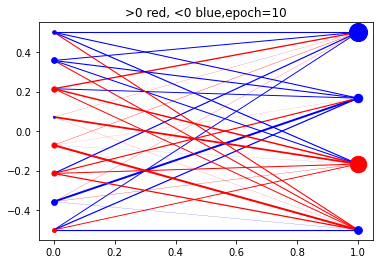

 l_rate= 0.6666666666666663


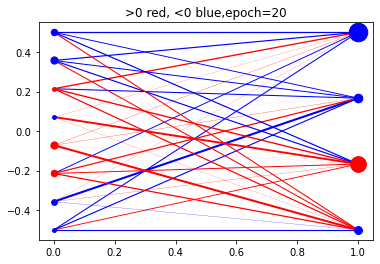

 l_rate= 0.5


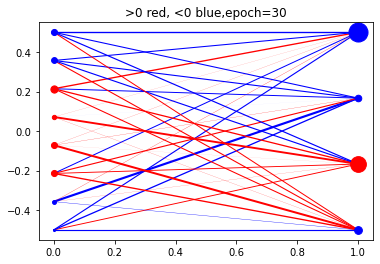

 l_rate= 0.4000000000000001


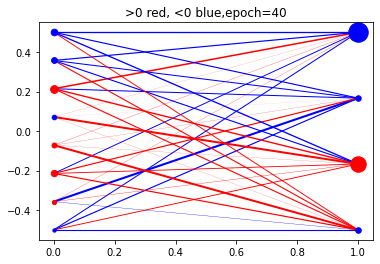

 l_rate= 0.3333333333333335


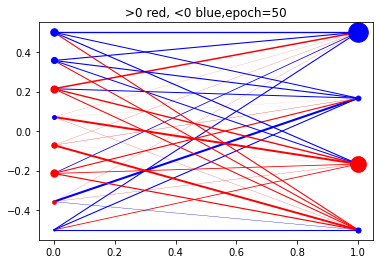

 l_rate= 0.28571428571428586


In [17]:
w,a,b = training_RBM(M,w,a,b)

In [18]:
#probability (null) of corruption for perfectly-generated data
q1 = 0

n_betas = 5
betas = np.linspace(0.5, 5.5, n_betas)

fname='DATA/dataRBM_q'+str(q1)+'_seq45.csv'
v_uncurrupted = np.loadtxt(fname, delimiter=',', dtype=int)

if SPINS:
    vmin = -1
    GAP = 2
    v_uncurrupted =  2*v_uncurrupted -1
else:
    vmin = 0
    GAP = 1

tots, percs = np.zeros((n_betas, n_betas)), np.zeros((n_betas, n_betas))

for i in range(n_betas):
    for j in range(n_betas):
        tot, perc = evaluate_beta(betas[j], betas[i], v0, v_uncurrupted, a, b, w)
        tots[i,j] = tot
        percs[i, j] = perc 

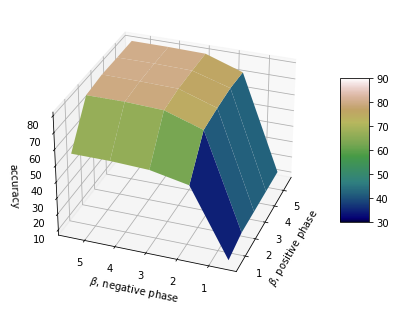

In [19]:
mountain_plot(betas, percs)

In [20]:
#accuracy of the dataset after denoising
acc_at_denois = np.max(percs)

#accuracy of the dataset before denoising
vdiff = np.sum(np.abs(v_uncurrupted-v0), axis=1)
tot = np.sum(vdiff) / (1-np.min(v_uncurrupted))
acc_bf_denois = np.unique(vdiff, return_counts=True)[1][0] / len(v_uncurrupted) * 100

## Larger error rate

We now see how the behaviour change when introducing a larger spin-flip probability, i.e. a larger error rate.


[0 1 1 0 1 0 1 1]
[1 1 0 1 1 0 0 1]
[1 1 1 0 0 0 1 1]
[0 0 1 1 1 1 0 0]
[0 0 1 1 0 0 1 0]
[1 1 1 0 1 0 0 0]
[1 1 1 0 1 1 0 0]
[1 1 0 0 0 1 1 1]
[1 0 0 1 1 1 0 1]
[1 0 0 0 0 0 1 0]


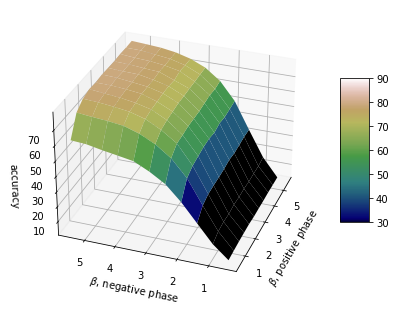

In [22]:
#corruption probability
q = 0.2

fname='DATA/dataRBM_q'+str(q)+'.csv'
v = np.loadtxt(fname, delimiter=',', dtype=int)
N=len(v)
L=len(v[0])

for n in range(10):
    print(v[n])
    
#here we select the encoding
SPINS = True

if SPINS:
    vmin = -1
    GAP = 2
    v =  2*v -1
else:
    vmin = 0
    GAP = 1
    
#store initial values before shuffling
v0 = np.copy(v)
#we construct here our RBM initializing randomly the weights

#number of hidden units
M = 3

sigma = np.sqrt(4. / float(N+M))

w = sigma * (2*np.random.rand(L, M) - 1) #from -sigma to sigma 
a = sigma * (2*np.random.rand(L) - 1)
b = np.zeros(M)


w,a,b = training_RBM(M,w,a,b, info=False)



#number of different betas and linspace
n_betas = 11
betas = np.linspace(0.5, 5.5, n_betas)

#probability (null) of corruption for perfectly-generated data
q1 = 0
fname='DATA/dataRBM_q'+str(q1)+'.csv'
v_uncurrupted = np.loadtxt(fname, delimiter=',', dtype=int)

if SPINS:
    vmin = -1
    GAP = 2
    v_uncurrupted =  2*v_uncurrupted -1
else:
    vmin = 0
    GAP = 1

tots, percs = np.zeros((n_betas, n_betas)), np.zeros((n_betas, n_betas))

for i in range(n_betas):
    for j in range(n_betas):
        tot, perc = evaluate_beta(betas[j], betas[i], v0, v_uncurrupted, a, b, w)
        tots[i,j] = tot
        percs[i, j] = perc 
        
        
        
        
        
mountain_plot(betas, percs)

Since, as expected, we notice a decrease in accuracy, due to how the dataset has been generated, we try to decrease the temperature w.r.t. the lower noise case studied before.
This leads to an increase of the accuracy of about 5$\%$, that displays a plateau at $\sim 80 \%$ accuracy

[0 1 1 0 1 0 1 1]
[1 1 0 1 1 0 0 1]
[1 1 1 0 0 0 1 1]
[0 0 1 1 1 1 0 0]
[0 0 1 1 0 0 1 0]
[1 1 1 0 1 0 0 0]
[1 1 1 0 1 1 0 0]
[1 1 0 0 0 1 1 1]
[1 0 0 1 1 1 0 1]
[1 0 0 0 0 0 1 0]


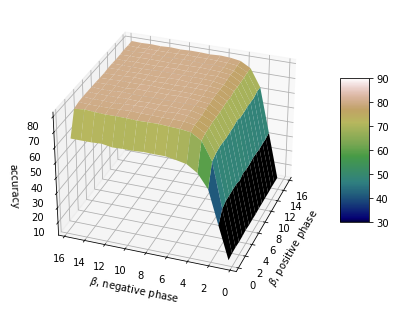

In [23]:
#corruption probability
q = 0.2

fname='DATA/dataRBM_q'+str(q)+'.csv'
v = np.loadtxt(fname, delimiter=',', dtype=int)
N=len(v)
L=len(v[0])

for n in range(10):
    print(v[n])
    
#here we select the encoding
SPINS = True

if SPINS:
    vmin = -1
    GAP = 2
    v =  2*v -1
else:
    vmin = 0
    GAP = 1
    
#store initial values before shuffling
v0 = np.copy(v)
#we construct here our RBM initializing randomly the weights

#number of hidden units
M = 3

sigma = np.sqrt(4. / float(N+M))

w = sigma * (2*np.random.rand(L, M) - 1) #from -sigma to sigma 
a = sigma * (2*np.random.rand(L) - 1)
b = np.zeros(M)


w,a,b = training_RBM(M,w,a,b, info=False)



#number of different betas and linspace
n_betas = 16
betas = np.linspace(0.5, 15.5, n_betas)

#probability (null) of corruption for perfectly-generated data
q1 = 0
fname='DATA/dataRBM_q'+str(q1)+'.csv'
v_uncurrupted = np.loadtxt(fname, delimiter=',', dtype=int)

if SPINS:
    vmin = -1
    GAP = 2
    v_uncurrupted =  2*v_uncurrupted -1
else:
    vmin = 0
    GAP = 1

tots, percs = np.zeros((n_betas, n_betas)), np.zeros((n_betas, n_betas))

for i in range(n_betas):
    for j in range(n_betas):
        tot, perc = evaluate_beta(betas[j], betas[i], v0, v_uncurrupted, a, b, w)
        tots[i,j] = tot
        percs[i, j] = perc 
        
        
        
        
mountain_plot(betas, percs)

#accuracy of the dataset after denoising
acc_at_denois = np.max(percs)

#accuracy of the dataset before denoising
vdiff = np.sum(np.abs(v_uncurrupted-v0), axis=1)
tot = np.sum(vdiff) / (1-np.min(v_uncurrupted))
acc_bf_denois = np.unique(vdiff, return_counts=True)[1][0] / len(v_uncurrupted) * 100

In [24]:
#accuracy of the dataset after denoising
acc_at_denois = np.max(percs)

#accuracy of the dataset before denoising
vdiff = np.sum(np.abs(v_uncurrupted-v0), axis=1)
tot = np.sum(vdiff) / (1-np.min(v_uncurrupted))
acc_bf_denois = np.unique(vdiff, return_counts=True)[1][0] / len(v_uncurrupted) * 100

print(acc_at_denois)

81.16


## Fifth state
qua è da sistemare l'M 

each of N=10000data samples has L=8 digits
[1 1 1 1 0 0 0 0]
[1 1 1 0 1 0 0 1]
[0 0 1 1 1 0 0 0]
[1 0 0 1 0 1 0 0]
[1 0 1 1 0 0 1 0]
[1 1 0 0 1 0 1 1]
[1 1 1 1 1 1 1 1]
[1 1 1 1 0 0 1 1]
[0 0 1 1 1 0 0 0]
[1 1 0 0 1 1 0 0]


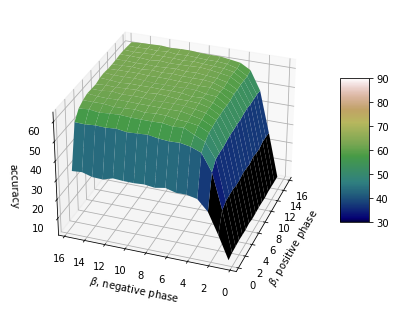

In [25]:
q = 0.2

fname='DATA/dataRBM_q'+str(q)+'_seq4.csv'
v = np.loadtxt(fname, delimiter=',', dtype=int)
N=len(v)
L=len(v[0])
print(f'each of N={N}data samples has L={L} digits')

for n in range(10):
    print(v[n])

SPINS = True
if SPINS:
    vmin = -1
    GAP = 2
    v =  2*v -1
else:
    vmin = 0
    GAP = 1
    
#store initial values before shuffling
v0 = np.copy(v)

#we construct here our RBM initializing randomly the weights

#number of hidden units
M = 4

sigma = np.sqrt(4. / float(N+M))

w = sigma * (2*np.random.rand(L, M) - 1) #from -sigma to sigma 
a = sigma * (2*np.random.rand(L) - 1)
b = np.zeros(M)

w,a,b = training_RBM(M,w,a,b, info=False)


#probability (null) of corruption for perfectly-generated data
q1 = 0

n_betas = 16
betas = np.linspace(0.5, 15.5, n_betas)

fname='DATA/dataRBM_q'+str(q1)+'_seq4.csv'
v_uncurrupted = np.loadtxt(fname, delimiter=',', dtype=int)

if SPINS:
    vmin = -1
    GAP = 2
    v_uncurrupted =  2*v_uncurrupted -1
else:
    vmin = 0
    GAP = 1

tots, percs = np.zeros((n_betas, n_betas)), np.zeros((n_betas, n_betas))

for i in range(n_betas):
    for j in range(n_betas):
        tot, perc = evaluate_beta(betas[j], betas[i], v0, v_uncurrupted, a, b, w)
        tots[i,j] = tot
        percs[i, j] = perc 
        
        
        
mountain_plot(betas, percs)

In [26]:
#accuracy of the dataset after denoising
acc_at_denois = np.max(percs)

#accuracy of the dataset before denoising
vdiff = np.sum(np.abs(v_uncurrupted-v0), axis=1)
tot = np.sum(vdiff) / (1-np.min(v_uncurrupted))
acc_bf_denois = np.unique(vdiff, return_counts=True)[1][0] / len(v_uncurrupted) * 100

## Sixth state

each of N=10000data samples has L=8 digits
[1 1 1 1 0 0 0 0]
[1 1 1 0 1 0 0 1]
[1 0 1 0 1 0 0 1]
[1 1 1 0 0 1 1 0]
[1 0 1 0 1 0 0 1]
[1 1 1 1 1 1 1 1]
[0 1 0 1 1 0 1 1]
[0 0 1 0 1 1 1 0]
[1 0 1 1 1 1 0 0]
[1 0 0 1 0 0 1 1]


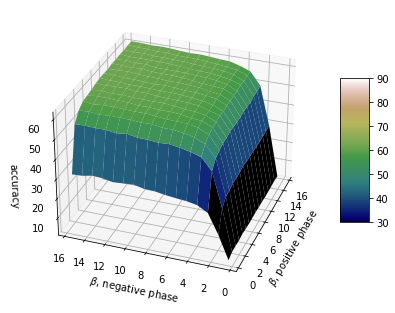

In [27]:
q = 0.2

fname='DATA/dataRBM_q'+str(q)+'_seq45.csv'
v = np.loadtxt(fname, delimiter=',', dtype=int)
N=len(v)
L=len(v[0])
print(f'each of N={N}data samples has L={L} digits')

for n in range(10):
    print(v[n])

SPINS = True
if SPINS:
    vmin = -1
    GAP = 2
    v =  2*v -1
else:
    vmin = 0
    GAP = 1
    
#store initial values before shuffling
v0 = np.copy(v)

#we construct here our RBM initializing randomly the weights

#number of hidden units
M = 4

sigma = np.sqrt(4. / float(N+M))

w = sigma * (2*np.random.rand(L, M) - 1) #from -sigma to sigma 
a = sigma * (2*np.random.rand(L) - 1)
b = np.zeros(M)

w,a,b = training_RBM(M,w,a,b, info=False)

#probability (null) of corruption for perfectly-generated data
q1 = 0

n_betas = 16
betas = np.linspace(0.5, 15.5, n_betas)

fname='DATA/dataRBM_q'+str(q1)+'_seq45.csv'
v_uncurrupted = np.loadtxt(fname, delimiter=',', dtype=int)

if SPINS:
    vmin = -1
    GAP = 2
    v_uncurrupted =  2*v_uncurrupted -1
else:
    vmin = 0
    GAP = 1

tots, percs = np.zeros((n_betas, n_betas)), np.zeros((n_betas, n_betas))

for i in range(n_betas):
    for j in range(n_betas):
        tot, perc = evaluate_beta(betas[j], betas[i], v0, v_uncurrupted, a, b, w)
        tots[i,j] = tot
        percs[i, j] = perc 
        
        
mountain_plot(betas, percs)


#accuracy of the dataset after denoising
acc_at_denois = np.max(percs)

#accuracy of the dataset before denoising
vdiff = np.sum(np.abs(v_uncurrupted-v0), axis=1)
tot = np.sum(vdiff) / (1-np.min(v_uncurrupted))
acc_bf_denois = np.unique(vdiff, return_counts=True)[1][0] / len(v_uncurrupted) * 100

## 5) Binary encoding

We now change the encoding to the 'bits' format, namely with 0's and 1's in the sequences.

In [52]:
#we load the sequences generated with the file coded at lesson

#corruption probability
q = 0.1

fname='DATA/dataRBM_q'+str(q)+'.csv'
v = np.loadtxt(fname, delimiter=',', dtype=int)
N=len(v)
L=len(v[0])
print(f'each of N={N}data samples has L={L} digits')

for n in range(10):
    print(v[n])

#changing the encoding
SPINS = False

if SPINS:
    vmin = -1
    GAP = 2
    v =  2*v -1
else:
    vmin = 0
    GAP = 1
    
#store initial values before shuffling
v0 = np.copy(v)

each of N=10000data samples has L=8 digits
[0 1 0 0 1 0 1 1]
[1 1 0 1 1 0 0 1]
[0 1 1 1 0 0 1 1]
[0 0 1 1 1 1 0 0]
[0 0 1 1 0 0 1 0]
[1 1 0 0 1 0 0 0]
[0 1 1 0 1 1 0 0]
[1 1 0 0 0 0 1 1]
[1 0 0 1 1 1 0 1]
[1 0 0 0 0 0 1 0]


In [53]:
#we construct here our RBM initializing randomly the weights

#number of hidden units
M = 3

sigma = np.sqrt(4. / float(N+M))

w = sigma * (2*np.random.rand(L, M) - 1) #from -sigma to sigma 
a = sigma * (2*np.random.rand(L) - 1)
b = np.zeros(M)

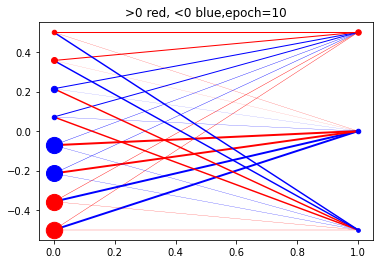

 l_rate= 0.6666666666666663


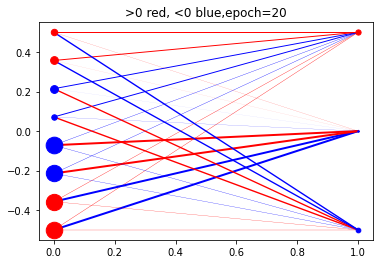

 l_rate= 0.5


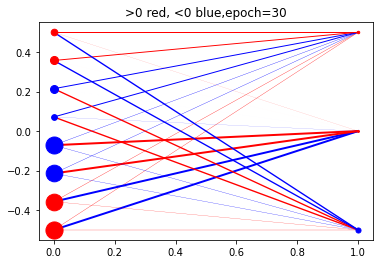

 l_rate= 0.4000000000000001


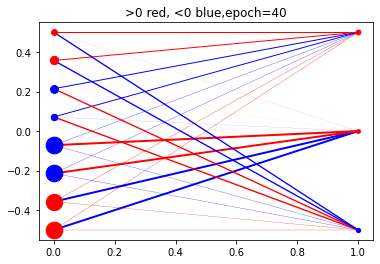

 l_rate= 0.3333333333333335


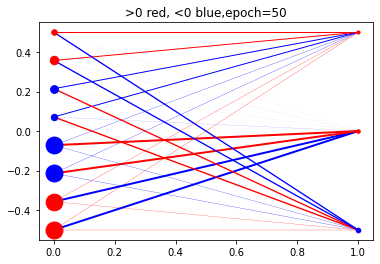

 l_rate= 0.28571428571428586


In [54]:
#minibatches
mini, m = 500, 0 
#epochs
nepoch = 50
#l_rate
l_rate = 1.
#dw
weights_bit = np.zeros(nepoch)

for epoch in range(1, 1+nepoch):
    for n in range(N):
        if m==0:
            #initialize
            v_data, v_model = np.zeros(L), np.zeros(L) 
            h_data, h_model = np.zeros(M), np.zeros(M) 
            vh_data, vh_model = np.zeros((L,M)), np.zeros((L, M)) 

        #positive CD phase
        h = activate(v[n],w,b,GAP)
        #negative CD phase
        vf = activate(h, w.T,a,GAP)
        #positive CD nr 2
        hf = activate(vf,w,b, GAP)

        v_data += v[n]
        v_model += vf
        h_data += h
        h_model += hf
        vh_data += np.outer(v[n].T, h)
        vh_model += np.outer(vf.T, hf)

        m += 1
        if m==mini:
            C = l_rate / mini
            dw = C*(vh_data - vh_model)
            da = C*(v_data - v_model)
            db = C * (h_data - h_model)
            weights_bit[epoch-1] = mean_square_increment(dw)
            w += dw
            a += da
            b += db
            m = 0
            
    #randomize order
    np.random.shuffle(v)
    l_rate = l_rate / (0.05 * l_rate + 1)
    if (epoch % 10 == 0):
        plotgraph(M,epoch)
        print(' l_rate=', l_rate)

In [55]:
#number of different betas and linspace
n_betas = 11
betas = np.linspace(0.5, 5.5, n_betas)

#probability (null) of corruption for perfectly-generated data
q1 = 0
fname='DATA/dataRBM_q'+str(q1)+'.csv'
v_uncurrupted= np.loadtxt(fname, delimiter=',', dtype=int)

if SPINS:
    vmin = -1
    GAP = 2
    v_uncurrupted =  2*v_uncurrupted -1
else:
    vmin = 0
    GAP = 1

tots, percs = np.zeros((n_betas, n_betas)), np.zeros((n_betas, n_betas))

for i in range(n_betas):
    for j in range(n_betas):
        tot, perc = evaluate_beta(betas[j], betas[i], v0, v_uncurrupted, a, b, w)
        tots[i,j] = tot
        percs[i, j] = perc 

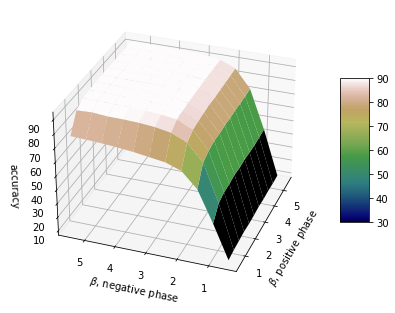

In [56]:
mountain_plot(betas, percs)

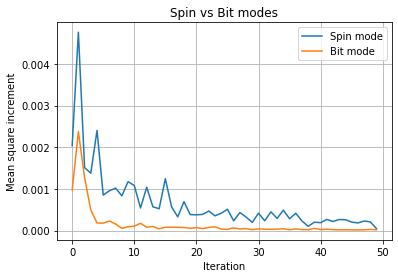

In [57]:
plt.plot(np.arange(nepoch),weights_spin, label = "Spin mode")
plt.plot(np.arange(nepoch),weights_bit, label = "Bit mode")
plt.xlabel('Iteration')
plt.ylabel('Mean square increment')
plt.title('Spin vs Bit modes')
plt.grid()
plt.legend()

plt.show()